In [1]:
################################
# Basic layout of the notebook #
################################
#
# 1. Load all prerequisites
# 2. Create a noise generator which outputs noise parameterized by some vars.
# 3. Create an adversary which creates adversarial images according to this noise generator.
# 4. Write a loop to display a few images (real image, regular noise, adversarial)
#
# (Unused)
# 4a. Write a loop to display a few images (real image, regular noise, adv 1, 3, 10 steps.)
# 4b. Write a function to display the averages (real image, regular noise, adv 1, 3, 10 steps.)

#########################################
# Basic layout of the problem statement #
#########################################
#
# 1. You have an image x.
# 2. You can modifiy x by adding adversarial noise to x.
# 2a. There are restrictions on the parameterization of the adversarial noise
# 2b. There are restrictions on the scale of the adversarial noise (?)


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.model_zoo as model_zoo
import torchvision
import torchvision.datasets as dset
import torchvision.models as models
import torchvision.transforms as trn
import skimage as sk
import os

%matplotlib inline
BASE_DIR = "/accounts/projects/jsteinhardt/akularora"

In [3]:
if torch.cuda.is_available():
    dev = "cuda:0" # check for available gpu
    print("Using GPU")
else:
    dev = "cpu"
    print("Using CPU")

device = torch.device(dev)  

Using GPU


In [4]:
test_transform = trn.Compose([trn.Resize(256), trn.CenterCrop(224), trn.ToTensor()])

mean = torch.FloatTensor(np.array([0.485, 0.456, 0.406]).reshape(1,3,1,1)).cuda()
std = torch.FloatTensor(np.array([0.229, 0.224, 0.225]).reshape(1,3,1,1)).cuda()

test_data = dset.ImageFolder(os.path.join(BASE_DIR, 'imagenette/imagenette2-320/val'), transform=test_transform)

test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True,
                                          num_workers=1, pin_memory=True)

In [5]:
def remove_module(state_dict):
    d = {}
    for key in state_dict:
        d[key[7:]] = state_dict[key]
    return d

net = models.resnet50()
'''
net.load_state_dict(model_zoo.load_url('https://download.pytorch.org/models/resnet50-19c8e357.pth',
                                       model_dir='/home/hendrycks/datasets/models'))
'''
session = torch.load(os.path.join(BASE_DIR, 'models/deepaugment_and_augmix.pth.tar'), map_location=torch.device('cuda'))
state_dict = remove_module(session['state_dict'])
net.load_state_dict(state_dict)
#'''
net.eval()
net.cuda()
cudnn.benchmark = True  # fire on all cylinders

In [6]:
to_np = lambda z: z.to('cpu').detach().numpy()

In [7]:
for i, (x, label) in enumerate(test_loader):
    image = x
    break
eps = 8./255
img = image

In [8]:
eps = 10000
from attacks.blur import BlurAdversary_PGD_linf
adv = BlurAdversary_PGD_linf(eps)


Clean Image
Loss: 21.102001
Wrong Prediction


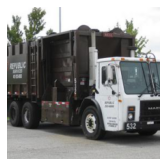


Adversarial Blur
Loss: 22.21854
Wrong Prediction


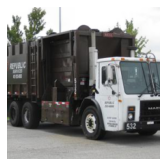

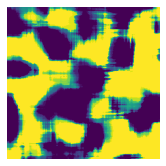


Clean Image
Loss: 0.16355218
Right Prediction


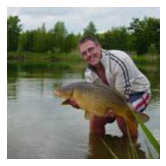


Adversarial Blur
Loss: 0.25584465
Right Prediction


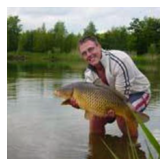

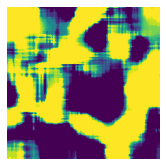


Clean Image
Loss: 19.944376
Wrong Prediction


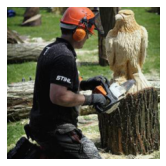


Adversarial Blur
Loss: 21.308813
Wrong Prediction


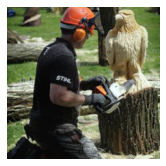

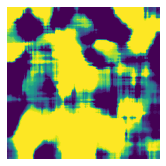

In [9]:
for i, (x, label) in enumerate(test_loader):
    if i < 3:
    
        print('\nClean Image')
        target = torch.LongTensor([label]).cuda()

        x = x.cuda()
        x_max, _ = torch.max(x.view(x.size(0), 3, -1), -1)
        x_max = x_max.view(-1, 3, 1, 1)

        logits = net((x - mean)/std)
        print('Loss:', to_np(F.cross_entropy(logits, target)))
        print(['Wrong Prediction', 'Right Prediction'][int(label == to_np(torch.argmax(logits, 1))[0])])
        
        plt.subplot(1,2,1) # induced for comparable size
        plt.imshow(to_np(x).squeeze().transpose((1,2,0)))
        plt.axis('off')
        plt.show()

        print('\nAdversarial Blur')

        adv_x, blur = adv(net, x, target, x_max, mean, std)
        
        logits = net((adv_x/x_max - mean)/std)
        print('Loss:', to_np(F.cross_entropy(logits, target)))
        print(['Wrong Prediction', 'Right Prediction'][int(label == to_np(torch.argmax(logits, 1))[0])])
        
        plt.subplot(1,2,1)
        plt.imshow(to_np(adv_x).squeeze().transpose((1,2,0)))
        plt.axis('off')
        plt.show()
        
        plt.subplot(1,2,2)
        plt.imshow(to_np(blur))
        plt.axis('off')
        plt.show()
        
    else:
        break

# print((max_temp - min_temp).mean())